In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from scipy import stats
from scipy.stats import norm, mannwhitneyu, normaltest

%matplotlib inline

from tqdm.auto import tqdm

# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [2]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-merinov-24/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-merinov-24/shared/problem1-auth_data.csv', sep=';')

## get_df

#### get_df (registration_df, date_column_reg, authorization_df, date_column_auth, user_id)

возвращает датафрейм с датой регистрации и авторизации по каждому id пользователя

Parameters: 

            registration_df - датафрейм с датой регистрации пользователей

            authorization_df - датафрейм с датой авторизации пользователей
            
            date_column_reg - str, названия столбца с датой регистрации пользователя
            
            date_column_auth - str, названия столбца с датой авторизации пользователя
            
            user_id - str, названия столбца с id пользователя

In [3]:
def get_df (registration_df, date_column_reg, authorization_df, date_column_auth, user_id):
    registration_df['date'] = registration_df[date_column_reg].apply(lambda d: datetime.fromtimestamp(d))
    authorization_df['date'] = authorization_df[date_column_auth].apply(lambda d: datetime.fromtimestamp(d))
    
    all_data = registration_df.merge(authorization_df,how='left', on=f'{user_id}')
    all_data = all_data.rename(columns={'date_x': 'reg_date', 'date_y': 'auth_date'})
    
    return all_data

## get_retention

#### get_retention(all_data)

возвращает сводную таблицу с уровнем retention 

Parameters: 

            all_data - датафрейм с данными по регистрации и авторизации пользователей
            lineplot - boolean, True - возвращает график
            distance - int, кол-во дней для подсчета retention

In [4]:
def get_retention(all_data, lineplot = False, distance = None):
   
    all_data['distance'] = (all_data.auth_date - all_data.reg_date).dt.days
    ret = all_data.groupby('distance').agg({'uid': 'nunique'})
    ret['retention'] = ret.uid.div(ret.uid[0])
    
    if lineplot:
        if distance != None:
            return sns.lineplot(data=ret.query(f'distance < {distance + 1}'), x='distance', y='retention')
        return sns.lineplot(data=ret, x='distance', y='retention')
    else:
        return ret

In [5]:
new = get_df(reg_data, 'reg_ts', auth_data, 'auth_ts', 'uid')

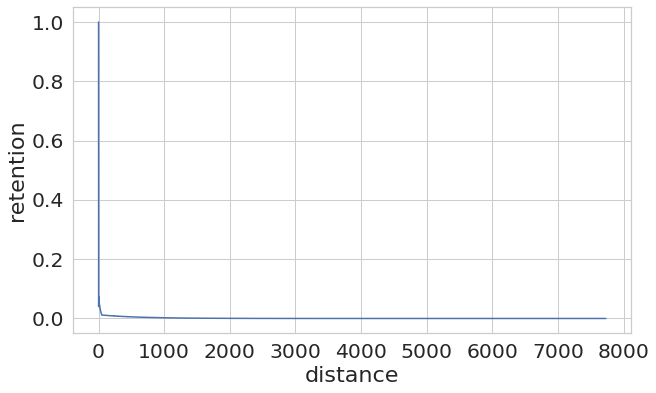

In [62]:
reten = get_retention(new, lineplot=True)

## get_retention_cohort

#### get_retention_cohort(all_data, cohort='M', distance=None)

возвращает сводную таблицу с уровнем retention 

Parameters: 

            all_data - датафрейм с данными по регистрации и авторизации пользователей
            cohort - str, делит пользователей на когорты 
                M -месяц
                Y - год
                W - неделя
                d - день
            distance - int, кол-во дней для подсчета retention
            percent - bool, 
                True  - возвращает retention процентах
                False - показывает абсолютное значение
            

In [24]:
def get_retention_cohort(all_data, cohort='M', distance=30, percent=True):
    
    #создаем когорты поьзователей
    all_data['cohort'] = all_data.reg_date.dt.to_period(f'{cohort}')
    
    #расчитываем дистанцию 
    all_data['distance'] = (all_data.auth_date - all_data.reg_date).dt.days
    
    # созщдаем своднуб таблицу для отображения результатов
    cohort_pivot_table = pd.pivot_table(all_data.query(f'distance <= {distance}]'), 
                                        index='cohort', 
                                        columns='distance', 
                                        values='uid', 
                                        aggfunc=pd.Series.nunique)
    if percent:
        cohort_pivot_table_div= cohort_pivot_table.div(cohort_pivot_table[0], axis=0).drop(0, axis=1)    
        return cohort_pivot_table_div
    else:
        return cohort_pivot_table

In [12]:
start_date = '2020-06-01'
end_date = '2020-06-30'
new1 = new.query('reg_date >= @start_date and reg_date <= @end_date')

In [23]:
get_retention_cohort(new1, cohort='M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


distance,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
cohort,,,,,,,,,,,,,,,,,,,,,
2020-06,0.03798,0.043519,0.049899,0.055586,0.064166,0.072375,0.043841,0.05158,0.052075,0.051877,...,0.037387,0.037412,0.035829,0.033826,0.031848,0.032887,0.032367,0.030167,0.029178,0.027694


In [14]:
get_retention(new1)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,uid,retention
distance,,
0,40442,1.000000
1,1536,0.037980
2,1760,0.043519
3,2018,0.049899
4,2248,0.055586
...,...,...
110,72,0.001780
111,62,0.001533
112,34,0.000841


# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-merinov-24/shared/problem2.csv', sep = ';')

In [3]:
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Для начала проведем анализ описательной статистики по нашим данным.
Мы можем заметить, что медианное значение равно 0 - это значит, что более 50% всех пользователей не совершали покупки.

In [4]:
# описательная статистика по полю revenue
df.groupby('testgroup').agg({'user_id': 'count', 'revenue': ['sum', 'mean', 'median']})

user_id  revenue                  
            count      sum       mean median
testgroup                                   
a          202103  5136189  25.413720      0
b          202667  5421603  26.751287      0

Посмотрим более подробно на описательную статистику по всеиму df и отдельно по каждой группе

In [6]:
df.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [7]:
df.query('testgroup == "a"').revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [8]:
df.query('testgroup == "b"').revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [67]:
df.query('testgroup == "a" and revenue > 1000').revenue

416       37324
4428      37304
5777      37315
8065      37307
8743      37334
          ...  
360696    37347
378668    37297
389341    37298
394580    37302
399294    37321
Name: revenue, Length: 123, dtype: int64

In [68]:
df.query('testgroup == "a" and revenue < 1000').revenue.max()

400

Наблюдается интересная ситуация: в контрольной группе максимальное значение "revenue" выше, чем в тестовой.

Можно предположить, что это связано с тем, что существует группа пользователей в нашей игре, которая тратит довольно большое кол-во денег на внутриигровые покупки. Однако очень странно, что ни один из них не попал в тестовую группу.

Скорее всего есть какой-то баг в системе по подсчету доходов с пользователей так, как каждый из этой выборки имеет значение от 37000, что довольно странно. Либо в нашей игре есть определенный лимит по внутриигровым покупкам, и чтобы купить все предметы надо потратить около  37000. 

Как я думаю, в таком случае наблюдался бы плавный переход между пользователями в зависимости от их покупок. В нашем случае, если не считать данную группу, то максимальный revenue составялет 400.
Поэтому остановимся на варианте, что это баг и не будем учитывать в дальнейшем.

In [148]:
# расчет краткой описательнйо статистике по очищенным данным для всех пользователей
df.query('revenue < 10000').groupby('testgroup').agg({'user_id': 'count', 'revenue': ['sum', 'mean', 'median']})

user_id  revenue                  
            count      sum       mean median
testgroup                                   
a          201980   545937   2.702926      0
b          202667  5421603  26.751287      0

Убрав выбросы, можно заметить, как сильно сократился ARPU в контрольной выборке, что говорит о сильном их влиянии. И тут уже без проведения статистических тестов видно, что в тестовой выборке ARPU значительно выше 

In [149]:
# расчет краткой описательнйо статистике по очищенным данным для платящих пользователей
df.query('0 < revenue < 10000').groupby('testgroup').agg({'user_id': 'count', 'revenue': ['sum', 'mean', 'median']})

user_id  revenue                    
            count      sum         mean median
testgroup                                     
a            1805   545937   302.458172    305
b            1805  5421603  3003.658172   3022

In [70]:
# выделим отдельно df с тестовой и контрольной выборками
df_test = df.query('testgroup == "b"')
df_control = df.query('testgroup == "a"')

Мы уже знаем, что более 75% пользователей не совершали покупки в нашей игре, но для анализа посмотрим на их распределение

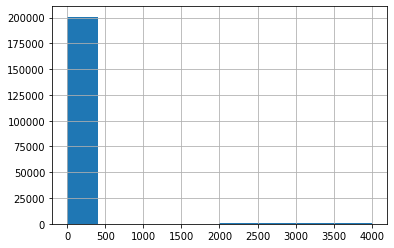

In [12]:
df_test.revenue.hist()

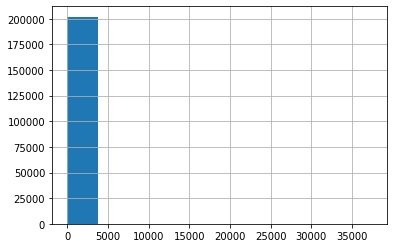

In [13]:
df_control.revenue.hist()

Для полноты анализа изучим не только измение ARPU, но и посмотрим только на платящих пользователей через ARPPU

In [142]:
# создаем новый дф с платящими пользователями по тестовой группе
df_test_pay = df.query('testgroup == "b" and revenue > 0')
# создаем новый дф с платящими пользователями по контрольной группе
df_control_pay = df.query('testgroup == "a" and 0 < revenue < 10000')

In [143]:
print('ARPPU_test = ', df_test_pay.revenue.mean())
print('ARPPU_control = ', df_control_pay.revenue.mean())
print('difference = ', f'{(df_test_pay.revenue.mean() / df_control_pay.revenue.mean() - 1) * 100} %')

ARPPU_test =  3003.6581717451522
ARPPU_control =  302.45817174515236
difference =  893.0821688216772 %


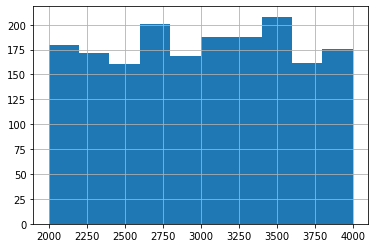

In [18]:
df_test_pay.revenue.hist()

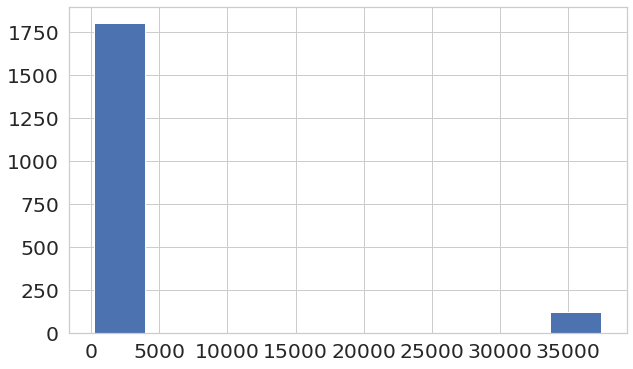

In [77]:
df_control_pay.revenue.hist()

Как ранее уже говорилось в контрольной выборке есть пользователи с большим revenue, поэтому уберем их из анализа

In [80]:
df_control_pay_normal = df_control_pay.query('revenue < 10000')

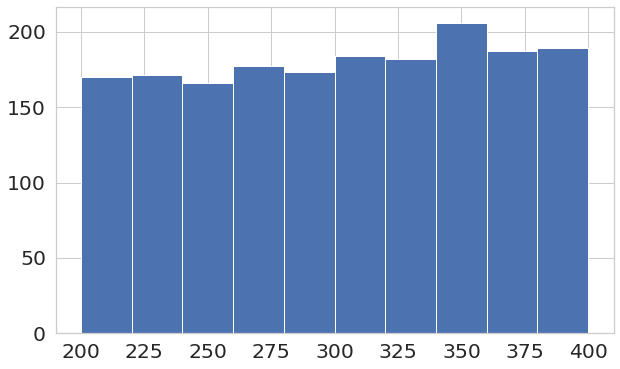

In [81]:
df_control_pay_normal.revenue.hist()

In [82]:
# проведем тест на нормальность распределения контрольной выборки без выбросов
normaltest(df_control_pay_normal.revenue)

NormaltestResult(statistic=1341.2009917493335, pvalue=5.779697118077758e-292)

In [83]:
# проведем тест на нормальность распределения тестовой выборки
normaltest(df_test_pay.revenue)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

Заметим, что распределение пользователей неравновмерно, что среди всех пользователей, что среди платящих.
Поэтому для дальнейшего анализа будем использовать bootstrap

In [84]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

#### Применим бутстрап (с np.mean) для анализа ARPU

H0: значимых различий в тестовой и контрольных выборках нет

H1: есть значимые различия в тестовой и контрольных выборках

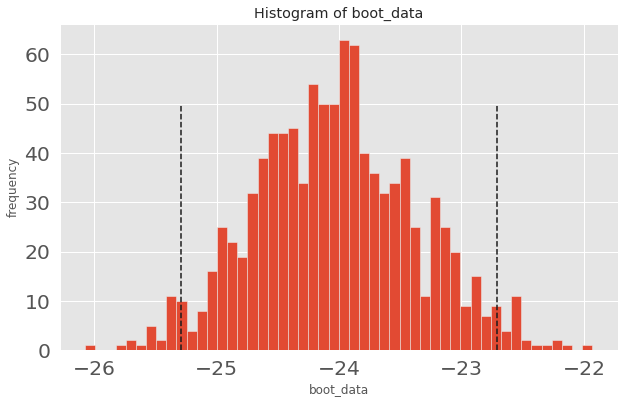

In [93]:
booted_data_test = get_bootstrap(df_control.query('revenue < 1000').revenue, df_test.revenue, statistic=np.mean)

In [100]:
booted_data_test["p_value"]

9.797589450122376e-298

In [101]:
booted_data_test['ci']

,0
0.025,-25.294508
0.975,-22.706158


Согласно проведенному тесту видим, что значение p_value < 0.05 и доверительный интервал имеет границы [-25.294508; -22.706158], в который не попадает 0. 
Таким образом, можно отклонить нулевую гипотезу на заданном уровне значимости.

#### Применим бутстрап (с np.mean) для анализа ARPPU

H0: значимых различий в тестовой и контрольных выборках нет

H1: есть значимые различия в тестовой и контрольных выборках

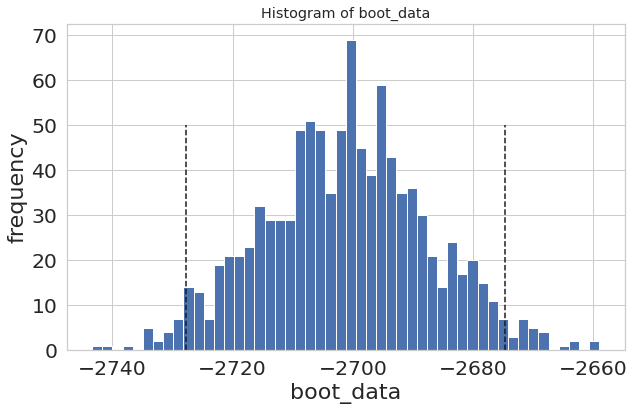

In [85]:
booted_data = get_bootstrap(df_control_pay_normal.revenue, df_test_pay.revenue, statistic=np.mean)

In [86]:
booted_data["p_value"]

0.0

In [87]:
booted_data["ci"]

,0
0.025,-2727.749612
0.975,-2674.694765


Согласно проведенному тесту видим, что значение p_value < 0.05 и доверительный интервал имеет границы [-2727.749612; -2674.694765], в который не попадает 0. 
Таким образом, можно отклонить нулевую гипотезу на заданном уровне значимости.

#### Для полноты эксперимента можно провести аналогичный тест, но с медианой 

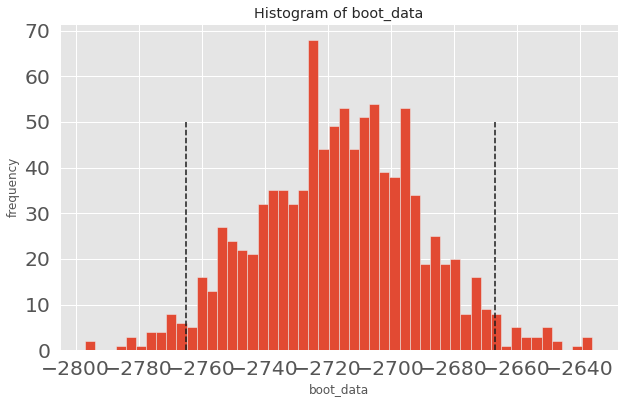

In [88]:
booted_data_median = get_bootstrap(df_control_pay_normal.revenue, df_test_pay.revenue, statistic=np.median)

In [97]:
booted_data_median["ci"]

,0
0.025,-2765.025
0.975,-2666.975


In [99]:
booted_data_median["ci"]

,0
0.025,-2765.025
0.975,-2666.975


Получим аналогичные результаты, а именно значение p_value < 0.05 и доверительный интервал имеет границы [-2765.025; -2666.975], в который не попадает 0. 
Таким образом, можно отклонить нулевую гипотезу на заданном уровне значимости.

### Выводы
1. Акционный набор предложений можно считать лучшим,как по показателю ARPU, так и по ARPPU.
2. В тестовой группе наблюдается статистически значимое увеличение revenue как по среднему значению, так и по медиане

# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

_______________________________________________________________________________________________________________________________

#### Стандартные метрики

- MAU
- DAU
- WAU
- Retention (можно посмотреть как отдельно для игрового события, так и взять вреям отсчета до: сколько пользователей вернулось в игру)


#### Кастомные метрики
1. кол-во пройденных уровней: 
    - среднее значение пройденных уровней 1 игроком
    - среднее значение пройденных уровней
2. кол-во дней проведенных в течение события:
    - среднее значение
    - среднее время 1 игрока в игре

** если в игре есть возможность за деньги скипнуть уровень**
3. кол-во купленных пропусков уровней 
    - среднее значение купленных прокусков
    - среднее кол-во купленных прокусков 1 игроком    